In [1]:
%tensorflow_version 2.x
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import OrderedDict
import math
import sys
import os
import time

In [2]:
FINAL_BATCH_SIZE=8

FINAL_SIZE=32
# Compute patch sizes such that final patches, despite rotation, never have null values
PATCH_SIZE=int(2*FINAL_SIZE/math.sqrt(2.0))

TARGET_CHANNELS = 1   # Number of channels in the target image (the first channels of the data pipeline)
SRC_IM_CHANNELS = 3   # Number of channels which come from the microscope images
PREPRO_CHANNELS = 3   # Number of channels arising from preprocessing steps
HIDDEN_CHANNELS = 6   # Number of CA state channels
CONV2D_CHANNELS = 128 # Number of channels in the hidden Conv2D layer

# Number of source parameter channels (the last channels of the data pipeline).
SOURCE_CHANNELS = SRC_IM_CHANNELS + \
                  PREPRO_CHANNELS 

NUM_ITER_MIN, NUM_ITER_MAX = 64, 96

IMG_PADDING = 2      # Number of pixels used to pad the target image border

N_DATA_CHANNELS = TARGET_CHANNELS + SOURCE_CHANNELS # Number of channels provided by the data pipeline
N_CELL_CHANNELS = TARGET_CHANNELS + HIDDEN_CHANNELS # Number of channels produced by one cell

In [3]:
SLICE_TARGET = np.s_[..., 0:TARGET_CHANNELS]
SLICE_SOURCE = np.s_[..., TARGET_CHANNELS:N_DATA_CHANNELS]
SLICE_HIDDEN = np.s_[..., TARGET_CHANNELS:N_CELL_CHANNELS]

In [4]:
def simple_sample(ds):
  for batch in ds.take(1):
    print(batch.shape) 

In [5]:
spatial_data = tf.data.Dataset.random().map(lambda k: tf.random.uniform([FINAL_BATCH_SIZE, FINAL_SIZE, FINAL_SIZE, N_DATA_CHANNELS]))
# spatial_data = tf.data.Dataset.from_generator(generate_spatial_data, output_types=tf.float32)
simple_sample(spatial_data)

(8, 32, 32, 7)


In [6]:
padded_data = spatial_data.map(lambda k: tf.pad(k, [(0, 0), (IMG_PADDING, IMG_PADDING), (IMG_PADDING, IMG_PADDING), (0, 0)]))

In [7]:
class CAModel(tf.keras.Model):

  def __init__(
      self, 
      target_channels=TARGET_CHANNELS, 
      source_channels=SOURCE_CHANNELS,
      hidden_channels=HIDDEN_CHANNELS,
      conv2d_channels=CONV2D_CHANNELS
    ):
    super().__init__()

    self.target_channels = target_channels
    self.source_channels = source_channels

    self.output_channels = target_channels + hidden_channels
    self.input_channels  = target_channels + source_channels + hidden_channels
    self.conv2d_channels = conv2d_channels

    self.dmodel = tf.keras.Sequential([
          tf.keras.layers.Conv2D(self.conv2d_channels, 1, activation=tf.nn.relu),
          tf.keras.layers.Conv2D(self.output_channels, 1, activation=None,
              # kernel_initializer=tf.zeros_initializer),
              # kernel_initializer=tf.random_normal_initializer(mean=0, stddev=np.power(2, 1/NUM_ITER_MAX))),
              kernel_initializer=tf.random_uniform_initializer(
                  minval=1-np.power(2, 1/NUM_ITER_MAX), 
                  maxval=np.power(2, 1/NUM_ITER_MAX)-1
              ),
              bias_initializer=tf.zeros_initializer)
    ])

    self(tf.zeros([1, 3, 3, self.input_channels]))  # dummy call to build the model

  @tf.function
  def perceive(self, x):
    identify = tf.constant([0.0, 1.0, 0.0], dtype=tf.float32)
    identify = tf.tensordot(identify, identify, axes=0)
    # dx = np.float32(np.outer([1.0, 2.0, 1.0], [-1.0, 0.0, 1.0]) / 8.0)  # Sobel filter
    dx = tf.tensordot([1.0, 2.0, 1.0], tf.constant([-1.0, 0.0, 1.0]) / 8.0, axes=0)  # Sobel filter
    dy = tf.transpose(dx)
    kernel = tf.stack([identify, dx, dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.input_channels, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x):
    y = self.perceive(x)
    dx = self.dmodel(y)*1

    old_yhat = x[..., 0:self.target_channels]
    old_hidden = x[..., self.target_channels+self.source_channels:]
    old_x = tf.concat([old_yhat, old_hidden], axis=-1)

    new_x = old_x + dx
    return new_x


CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 3, 3, 128)            5120      
                                                                 
 conv2d_1 (Conv2D)           (1, 3, 3, 7)              903       
                                                                 
Total params: 6,023
Trainable params: 6,023
Non-trainable params: 0
_________________________________________________________________


In [8]:
def split_data_into_source_and_target(spatial_data):
  return spatial_data[SLICE_SOURCE], spatial_data[SLICE_TARGET]

def construct_initial_model_input_from_source(source):
  return tf.pad(source, [(0, 0), (0, 0), (0, 0), (TARGET_CHANNELS, HIDDEN_CHANNELS)])

def split_model_output_into_yhat_hidden(model_output):
  return model_output[SLICE_TARGET], model_output[SLICE_HIDDEN]

def construct_model_input_from_yhat_source_hidden(yhat, source, hidden):
  return tf.concat([yhat, source, hidden], axis=-1)

In [22]:
from IPython.display import clear_output, display
hstack_np = lambda k: np.hstack(k.numpy())
vstack_np = lambda k: np.vstack(k.numpy())

def imshow(ax, array, title=None):
  # ax.cla()
  if array.shape[-1] == 1:
    array = array[..., 0]
  array_max = tf.reduce_max(array).numpy()
  array = hstack_np(array)

  if title is not None:
    ax.set_title(title, loc="left")
  

  ax_ims = ax.get_images()
  if len(ax_ims):
    ax_ims[0].set_data(array)
    ax_ims[0].set_clim(0, np.max([1, array_max]))
  else:
    ax.imshow(array, vmin=0, vmax=np.max([1, array_max]))

def plot_loss(ax, loss_log):
  ax.title('Loss history (log10)')
  ax.plot(np.log10(loss_log), '.', alpha=0.1)

In [16]:
@tf.function
def batch_image_norm(batched_img_array):
  batch_max = tf.reduce_max(batched_img_array, axis=[-3, -2, -1], keepdims=True)
  batch_min = tf.reduce_min(batched_img_array, axis=[-3, -2, -1], keepdims=True)
  
  normed = tf.cond(
      tf.reduce_all(tf.equal(batch_max, batch_min)),
      lambda: tf.identity((batched_img_array - batch_min) / (batch_max - batch_min)),
      lambda: tf.identity(batched_img_array)
  )

  # print("batch_image_norm:", batched_img_array.shape, normed.shape)

  return normed

@tf.function
def cell_loss_fn(y, yhat):
  # yhat = batch_image_norm(yhat)
  return tf.reduce_mean(tf.math.squared_difference(y, yhat), axis=-1)

# @tf.function
def train_step(source, target, ca, trainer):
  model_input = construct_initial_model_input_from_source(source)
  yhat = None # Keep this variable around in this scope

  iter_n = tf.random.uniform([], NUM_ITER_MIN, NUM_ITER_MAX, tf.int32)
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      model_output = ca(model_input)
      yhat, hidden = split_model_output_into_yhat_hidden(model_output)
      model_input = construct_model_input_from_yhat_source_hidden(yhat, source, hidden)
    cell_loss = cell_loss_fn(target, yhat)
    loss = tf.reduce_mean(cell_loss)
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))

  return loss, cell_loss, yhat, hidden


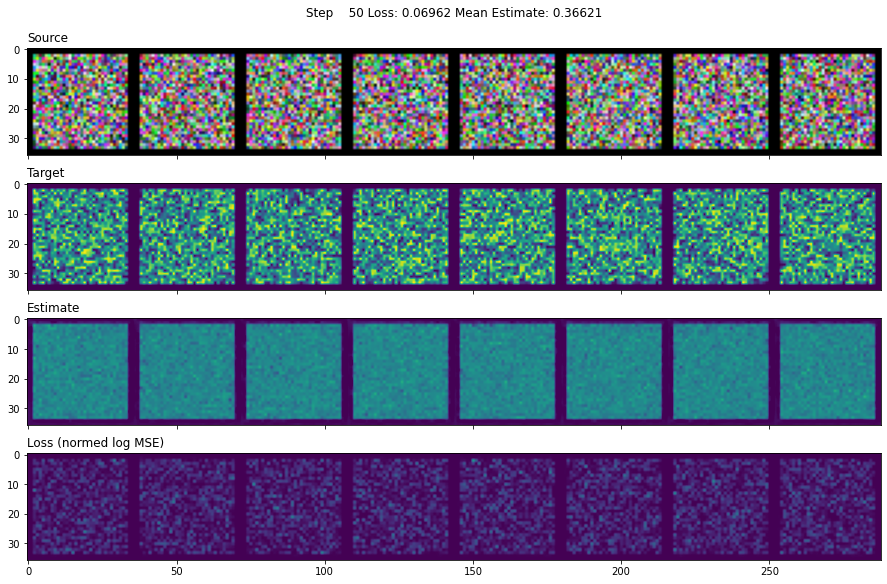

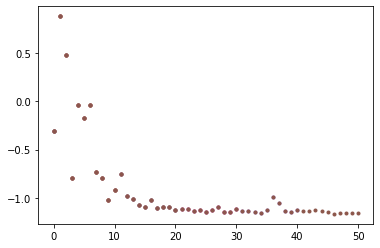

KeyboardInterrupt: ignored

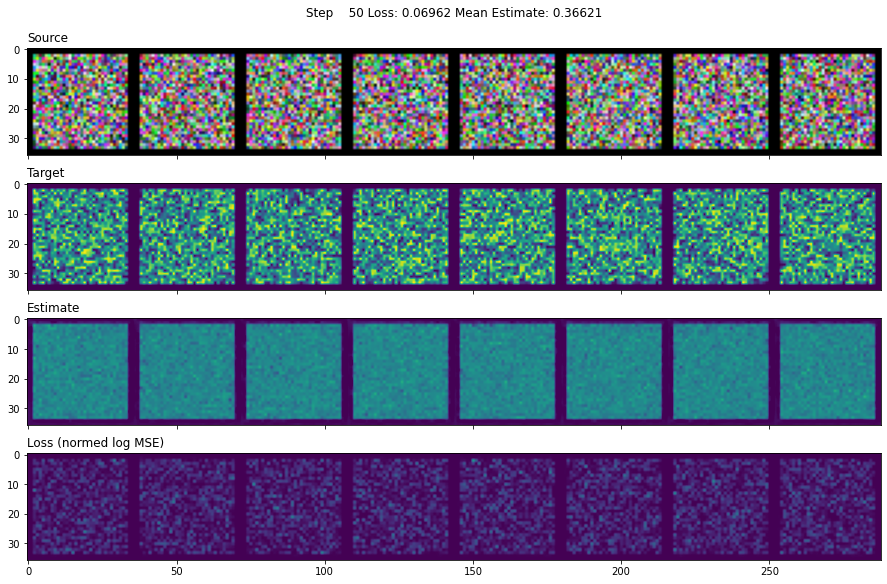

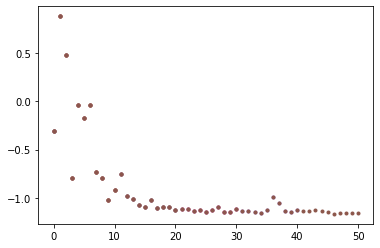

In [23]:
ca = CAModel()

loss_log = []

lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr, lr*0.1])
trainer = tf.keras.optimizers.Adam(lr_sched)

data_iter = iter(padded_data)
train_fn = lambda source, target: train_step(source, target, ca, trainer)
i = 0;

im_fig, im_axes = plt.subplots(4, 1, squeeze=False, sharex=True, sharey=True, figsize=(FINAL_BATCH_SIZE*2, 4*2), constrained_layout=True)
# im_fig.tight_layout()
# print(im_axes)
# for im_ax in im_axes:
#   im_ax.set_aspect(1.0/FINAL_BATCH_SIZE)

err_fig = plt.figure()
err_ax = err_fig.add_subplot(label="Loss")

for i in range(100+1):
  try:
    x0 = data_iter.get_next()
  except tf.errors.OutOfRangeError:
    print("OORE")
    data_iter = iter(padded_data)
    x0 = data_iter.get_next()
  
  source, target = split_data_into_source_and_target(x0)
  loss, cell_loss, yhat, hidden = train_fn(source, target)


  loss_log.append(loss.numpy())

  if i % 10 == 0:
    clear_output(wait=True)
    im_fig.suptitle(f"Step {i:5} Loss: {loss.numpy():2.5f} Mean Estimate: {tf.reduce_mean(yhat).numpy():2.5f}")
    imshow(im_axes[0, 0], source[..., :SRC_IM_CHANNELS], title="Source")
    imshow(im_axes[1, 0], target, title="Target")
    # imshow(im_axes[2], batch_image_norm(yhat), title="Estimate")
    imshow(im_axes[2, 0], yhat, title="Estimate")
    imshow(im_axes[3, 0], batch_image_norm(cell_loss), title="Loss (normed log MSE)")
    # imshow(im_axes[3], cell_loss, title="Loss")
    
    err_ax.plot(np.log10(loss_log), '.', alpha=1)
    display(im_fig)
    display(err_fig)
    